In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

# 1 Application

In [2]:
data = np.load('/home/kduplat/Documents/cours ML/TP_Filtrage/mydata_cluster.npz')

# Afficher les noms des tableaux stockés dans le fichier
print("Noms des tableaux dans le fichier :", data.files)

# Accéder à un tableau spécifique
tableau_psd = data['psd']
tableau_r = data['r']
tableau_y = data['y']
tableau_f = data['f']
print("Contenu du tableau :", tableau_psd)

# Fermer le fichier (optionnel mais recommandé pour de gros fichiers)
data.close()

Noms des tableaux dans le fichier : ['r', 'y', 'f', 'psd']
Contenu du tableau : [142.61281817 142.61281817  67.06471569  43.29306749  31.82027966
  25.11212913  20.73041364  17.65308587  15.37816886  13.63094387
  12.24870599  11.12909424  10.20456343   9.4287831    8.76893927
   8.20115536   7.70765295   7.27492807   6.89254367   6.5523087
   6.2477069    5.97349106   5.72538955   5.4998905    5.29408068
   5.10552363   4.93216635   4.77226701   4.62433832   4.48710294
   4.35945776   4.24044536   4.12923075   4.02508256   3.92735746
   3.83548737   3.74896883   3.66735407   3.5902436    3.51727984
   3.44814183   3.38254067   3.32021562   3.26093077   3.20447217
   3.15064536   3.09927315   3.05019383   3.00325947   2.95833451
   2.9152945    2.87402496   2.83442047   2.79638371   2.75982478
   2.72466046   2.69081361   2.65821265   2.62679104   2.59648688
   2.56724246   2.53900399   2.51172121   2.48534713   2.45983776
   2.43515191   2.41125091   2.38809849   2.36566054   2.343904

In [16]:
# Colored noise

def generate_gaussian_data(n, a, b):
    return np.random.normal(loc=a, scale=b, size=n)

def generate_col_noise(TPSD):
    bbg = generate_gaussian_data(len(TPSD), 0, 0.001)
    TF_bbg = np.fft.fft(bbg) 
    TF_bbg_bis = TF_bbg * np.sqrt(TPSD)
    TF_inv_bbg = np.fft.ifft(TF_bbg_bis)
    
    return TF_inv_bbg.real

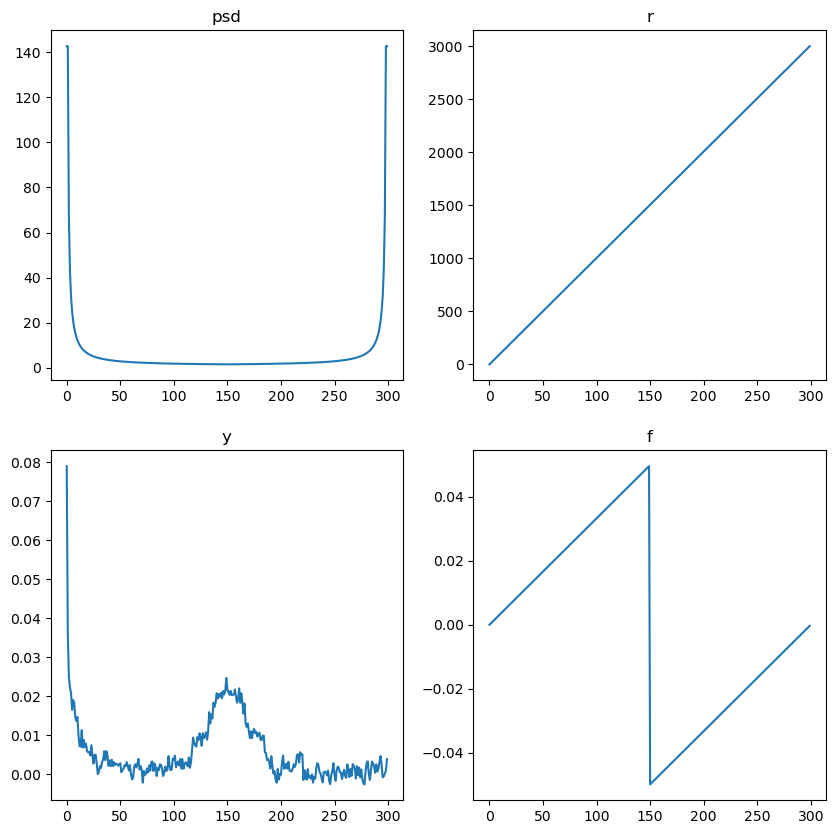

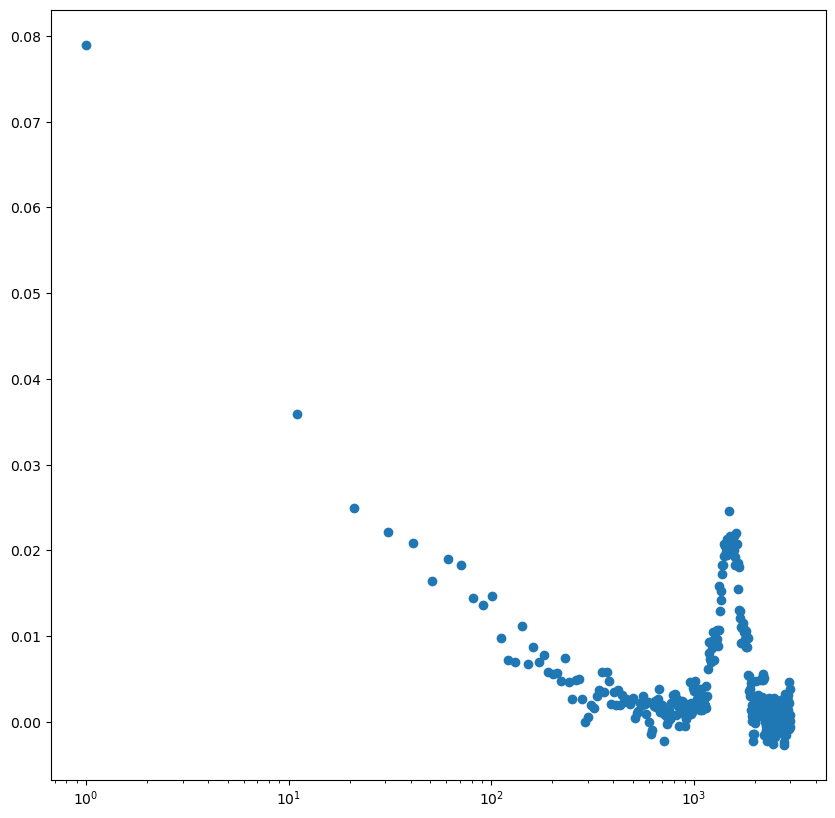

In [4]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.plot(tableau_psd)
plt.title('psd')
plt.subplot(2,2,2)

plt.plot(tableau_r)
plt.title('r')
plt.subplot(2,2,3)

plt.plot(tableau_y)
plt.title('y')
plt.subplot(2,2,4)
plt.plot(tableau_f)
plt.title('f')
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(tableau_r, tableau_y)
plt.xscale('log')
plt.show()

In [17]:
col_noise = generate_col_noise(tableau_psd)

## Noise generation

In [22]:
from numpy.linalg import inv

Cov = 0

nb_real = 10000
for i in range (nb_real):
    col_noise = generate_col_noise(tableau_psd)
    Cov += np.outer(col_noise.T, col_noise)
    
Cov = Cov/nb_real
Inv_Cov = inv(Cov)

In [7]:
a = 1.1
b = 5.5
c = 0.31


In [8]:
def gaussfct(x,A,x0,sigma):
    return A * np.exp(-(x - x0)**2/(2 * sigma**2))

def fct_densité(r, rp, rho_z, A, mu, sigma):
    
    gauss = gaussfct(r, A, mu, sigma)
    rho_r = rho_z/((r/rp)**c * (1 + (r/rp)**a)**((b-c)/a))
    return rho_r + gauss





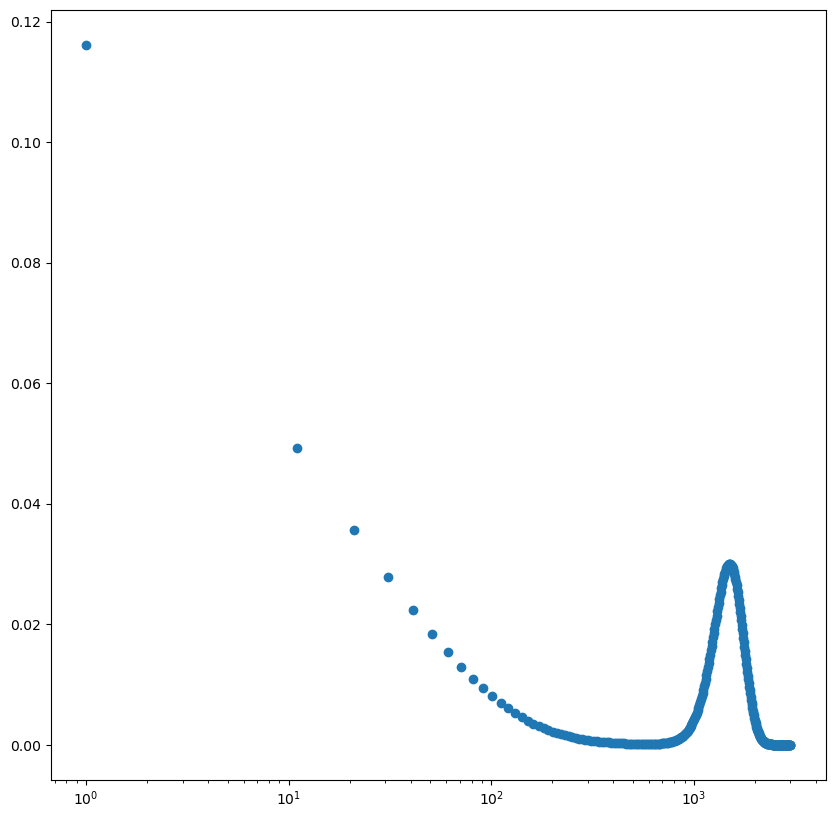

In [23]:
A = 0.03
mu = 1500
sigma = 250
rho_z = 0.02
rp = 300

params = [rp, rho_z, A, mu, sigma]
gaus_data = gaussfct(tableau_r, A, mu, sigma)

signal = fct_densité(tableau_r, rp, rho_z, A, mu, sigma)

plt.figure(figsize=(10, 10))
plt.scatter(tableau_r, signal)
plt.xscale('log')
plt.show()

rp = 901.106775343156, rho_z = 0.00939843995629463, A= 0.02110645881399912, mu= 1518.1927631585731, sigma= 204.88530355904697


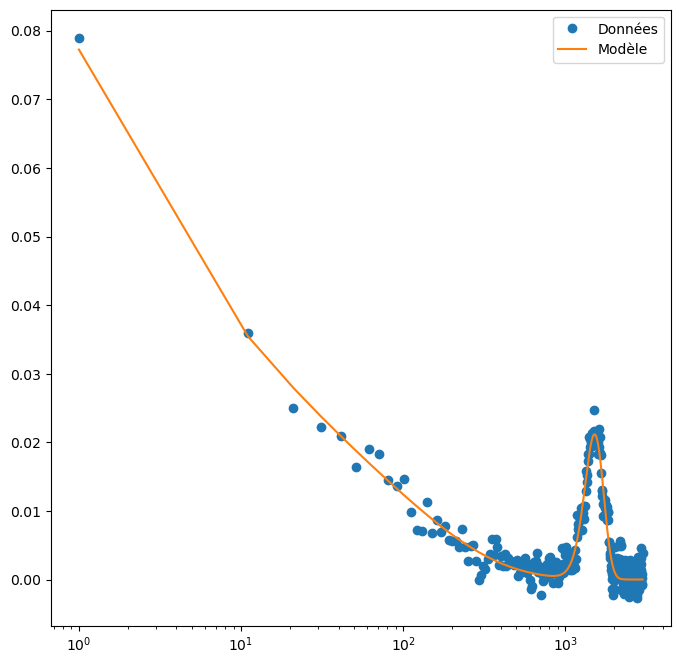

In [24]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(fct_densité, tableau_r,tableau_y, p0 = params)

rp_fit, rho_zfit, A_fit, mu_fit, sigma_fit = popt
print("rp = {}, rho_z = {}, A= {}, mu= {}, sigma= {}".format(rp_fit, rho_zfit, A_fit, mu_fit, sigma_fit))

y_fit = fct_densité(tableau_r, rp_fit, rho_zfit, A_fit, mu_fit, sigma_fit)
plt.figure(figsize=(8, 8))
plt.plot(tableau_r, tableau_y, 'o', label='Données')
plt.plot(tableau_r, y_fit, label='Modèle')
plt.xscale('log')
plt.legend()
plt.show()



In [27]:
from scipy.stats import chisquare

y_fit_normalized = y_fit * (sum(tableau_y) / sum(y_fit))

chi2 = chisquare(f_obs=tableau_y, f_exp=y_fit_normalized)

print(f"Chi2 statistic: {chi2.statistic}, p-value: {chi2.pvalue}")


chi2_2 = np.sum((tableau_y - y_fit)**2 / y_fit)

print ("Chi2 manual = ", chi2_2)


# CHI2 attendu

Chi2_mat = np.dot((tableau_y - y_fit).T, np.dot(Inv_Cov, (tableau_y - y_fit)))

print("Chi2 attendu = {} +/- {}".format(Chi2_mat, np.sqrt(2*295)))

# On s'attend àn avoir un Chi2 qui est égale à 300 - 5 (Nb de point - nb de degré de liberté)


Chi2 statistic: 34.248511756295606, p-value: 1.0
Chi2 manual =  36.48597771881528
Chi2 attendu = 271.11995954661774 +/- 24.289915602982237


In [12]:
vals = np.random.multivariate_normal(popt, pcov, 1000)


print(vals)

[[8.29060912e+02 9.35330095e-03 2.12277244e-02 1.51493099e+03
  2.01315572e+02]
 [9.30050394e+02 9.53254698e-03 2.04857230e-02 1.51403330e+03
  2.06559882e+02]
 [8.77567253e+02 9.71014582e-03 2.06944235e-02 1.51845812e+03
  2.04149441e+02]
 ...
 [8.92433845e+02 9.69960318e-03 2.08554085e-02 1.51607774e+03
  2.06849517e+02]
 [9.82130474e+02 8.97719335e-03 2.03916971e-02 1.52312735e+03
  2.10470784e+02]
 [7.84728490e+02 9.99460583e-03 2.12254313e-02 1.51970510e+03
  1.99779289e+02]]


In [13]:
from getdist import MCSamples, plots


names = ["rp", "rho_z", "A", "mu", "sigma"]
labels = ["rp", "rho_z", "A", "mu", "sigma"]

mcsamples = MCSamples(samples=vals, names=names, labels=labels)
mcsamples2 = MCSamples(samples=np.random.multivariate_normal(popt, pcov, 1000), names=names, labels=labels)


Removed no burn in
Removed no burn in


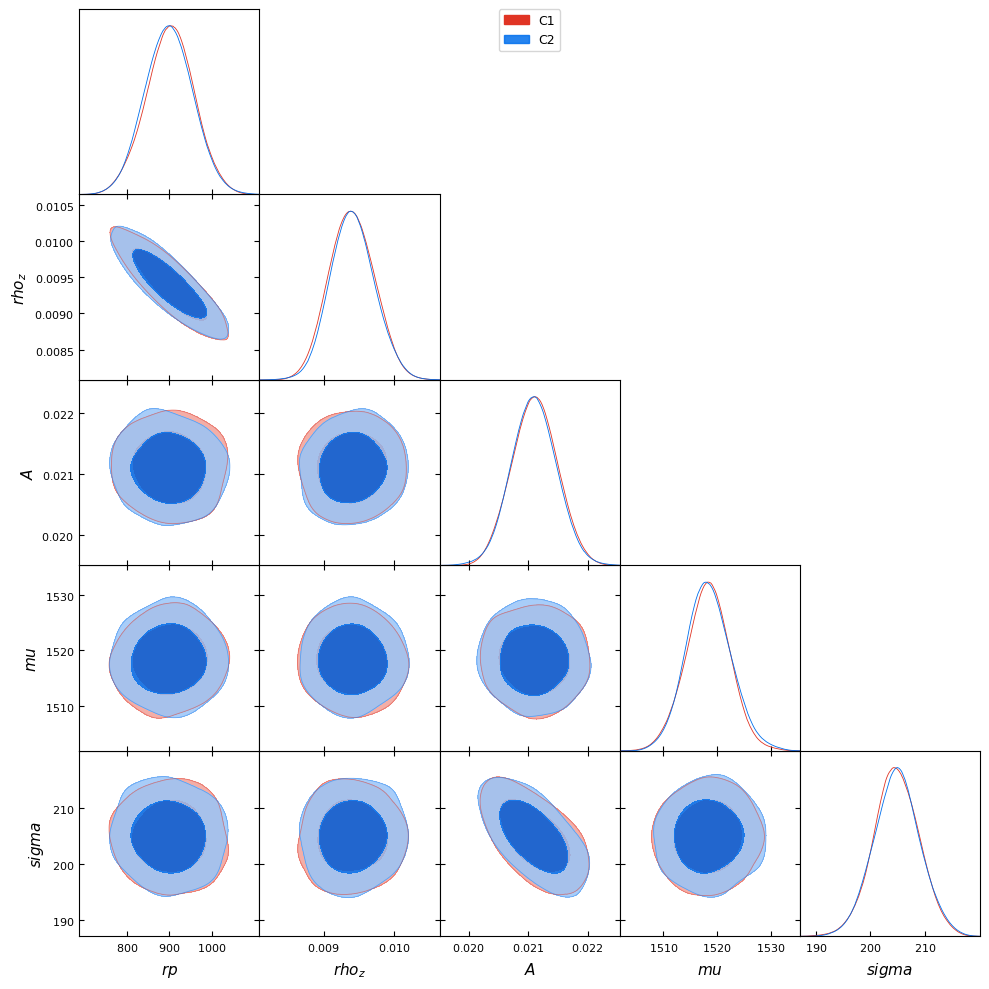

In [14]:
g = plots.get_subplot_plotter()

g.triangle_plot([mcsamples, mcsamples2], filled=True, legend_labels=["C1", "C2"])


# 1.2 MCMC

In [39]:
def generate_gaussian_data(a, b, n):
    return np.random.normal(loc=a, scale=b, size=n)

def params_def( teta, dteta):
    return np.random.normal(teta, dteta)


In [40]:
teta = [1,2,4,6,12]
dteta = [0.1,0.1,0.1,0.1,0.1]
teta_p = params_def(teta, dteta)

print(teta_p)


[ 0.96289455  2.06961636  3.97290307  6.12420395 12.11763225]


In [44]:
#rp = 901.106775343156, rho_z = 0.00939843995629463, A= 0.02110645881399912, mu= 1518.1927631585731, sigma= 204.88530355904697

def log_prior(params):
    rp, rho_z, A, mu, sigma = params
    if 0<rp and  0<rho_z  and 0 < A <0.05 and 1000 < mu < 3000 and 100 < sigma < 500:
        return 0
    else:
        return -np.inf

def log_likelihood(params):
    
    Vraisemblance = fct_densité(tableau_r, params[0], params[1], params[2], params[3], params[4])
    
    Chi2 = np.dot((tableau_y - Vraisemblance).T, np.dot(Inv_Cov, (tableau_y - Vraisemblance)))
    
    return (-1/2 * Chi2)

def log_acceptance(teta, teta_p):
    return log_likelihood(teta_p) + log_prior(teta_p) - log_likelihood(teta) - log_prior(teta)

def test_acceptance(teta, teta_p):
    if log_acceptance(teta, teta_p) >= np.log(np.random.uniform()):
        return teta_p
    else:
        return teta
    
    
def Metropolis_Hastings(teta_0, dteta_0, n_iter):
    teta = teta_0
    teta_list = [teta]
    for _ in range(n_iter):
        teta_p = params_def(teta, dteta_0)
        teta = test_acceptance(teta, teta_p)
        teta_list.append(teta)
    return teta_list

In [46]:
A = 0.03
mu = 1500
sigma = 250
rho_z = 0.02
rp = 300

teta_0 = [rp, rho_z, A, mu, sigma]
dteta_0 = np.array(teta_0) * 0.1
n_iter = 10000

teta_list = Metropolis_Hastings(teta_0, dteta_0, n_iter)

In [52]:
print(teta_list[1])

[3.18350849e+02 1.82708071e-02 3.20212402e-02 1.52974076e+03
 3.00191525e+02]


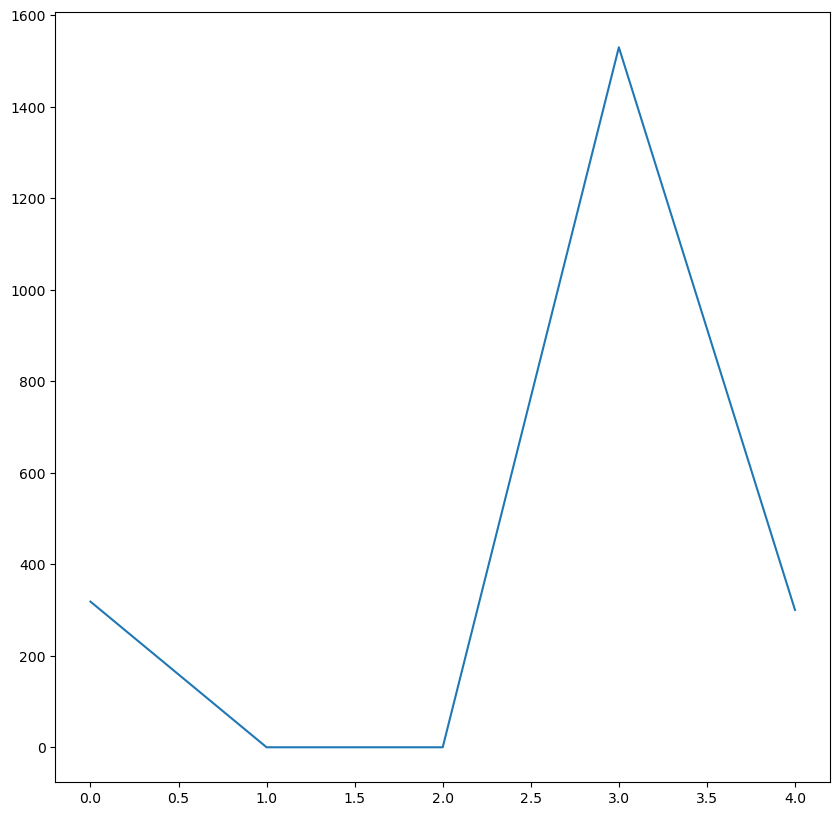

In [54]:
plt.figure(figsize=(10, 10))
plt.plot(np.array(teta_list[:][1]))
plt.show()